# Grover's Search Algorithm generalized for $n$ Qubits
**By:** Arjun Bhamra

### Problem Statement

We are given an unsorted list of length $n$, and we know what our target is. Our goal is to find our target with a quantum algorithm, specifically one that results in a *quadratic speedup*. In this case, **Grover's Search Algorithm**'s Big O is $O(\sqrt{n})$, as opposed to a classical algorithm of $O(n)$.

The oracle essentially *amplifies* the correct answer/target and "dims" the incorrect answer/everything that isn't the target.

### Imports

In [441]:
import qiskit
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit.extensions import UnitaryGate
from qiskit.extensions import Snapshot
import seaborn as sns
from seaborn import *
sns.set_theme(style="whitegrid")

In [442]:
IBMQ.load_account()
from qiskit.providers.ibmq import least_busy

/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-03-31 22:57:43,218: Credentials are already in use. The existing account in the session will be replaced.


### Making the Class

In [450]:
class GroverSearch():
    def __init__(self, target_state):
        self.n = len(target_state)
        self.target = target_state
        self.answer = "N/A"
        
    #generates a hadamard transformed state
    def h_transform(self, target):
        num_qubits = len(target)
        #1/np.sqrt(2**num_qubits) (scale factor for hadamard transform)
        h_state = 1/np.sqrt(2**num_qubits)*np.ones((2**num_qubits, 1))
        return h_state

    #Creates a statevector
    def create_sv(self, target):
        num_qubits = len(target)
        q0 = np.array([[1.], [0.]])
        q1 = np.array([[0.], [1.]])
        elements=q0 #by default
        iterate = q0 #by default

        #giving elements an initial value
        if(target[0]=="0"):
            elements=q0
        elif(target[0]=="1"):
            elements=q1

        for i in range(1, num_qubits):
            if(target[i]=="0"):
                iterate=q0
            elif(target[i]=="1"):
                iterate=q1

            elements = np.kron(elements, iterate)
        return elements
    
    def gsa(self):
        #setting up the circuit vars
        qr = qiskit.QuantumRegister(self.n, 'q')
        cr = qiskit.ClassicalRegister(self.n, 'c')
        qc = qiskit.QuantumCircuit(qr, cr)
        self.circuit=qc

        #creating the circuit
        #adding hadamards
        for q in qr:
            qc.h(q)
        qc.barrier()    

        #create Uw Oracle/Gate

        #Recall that Uw = I-2|w><w|

        uw_gate = np.identity(2**self.n)-2*np.kron(self.create_sv(self.target).T, self.create_sv(self.target))

        Uw_Gate = UnitaryGate(uw_gate, label="Uw-Oracle")

        # Create Us Diffuser Operator

        #Recall that Us = 2|s><s|-I
        s = self.h_transform(self.target)#snapshot of after the hadamard transform!
        us_gate = 2*np.kron(s.T, s)-np.identity(2**self.n)
        Us_Gate = UnitaryGate(us_gate, label="Us-Diffuser")

        #ADDING THE GROVER OPERATOR √N TIMES

        for i in range(0, int(np.sqrt(self.n))):
            qc.append(Uw_Gate, qr[:self.n])
            qc.append(Us_Gate, qr[:self.n])
            qc.barrier()
    
        #measurements
        qc.measure(qr[:self.n], cr[:self.n])
        
    def plot_counts_sim(self):
        # use local simulator
        qasm_sim = Aer.get_backend('qasm_simulator')
        shots = 1024
        qobj = assemble(self.circuit)
        results = qasm_sim.run(qobj).result()
        answer = results.get_counts()
        counts = answer
        x_list = list(counts.keys())
        #print(x_list)
        height_list = list(counts.values())
        #print(height_list)

        sns.barplot(x=x_list, y=height_list)
     
    def plot_counts_real(self):
        provider = IBMQ.get_provider(hub='ibm-q')
        backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= len(self.target)+1
                                    and not x.configuration().simulator
                                    and x.status().operational==True))
        print(backend)
        shots=1024
        transpiled = transpile(self.circuit, backend)
        qobj = assemble(transpiled)
        results = backend.run(qobj).result()
        answer = results.get_counts()
        counts = answer
        x_list = list(counts.keys())
        #print(x_list)
        height_list = list(counts.values())
        #print(height_list)

        sns.barplot(x=x_list, y=height_list)
        

#qc.draw('mpl')

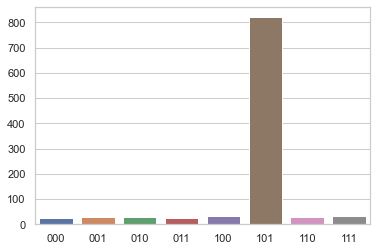

In [452]:
target_state = "101" #as an input in the class
gs = GroverSearch(target_state)
gs.gsa()
gs.plot_counts_sim()
#gs.plot_counts_real()

### Visualizations (Mostly for the circuit)

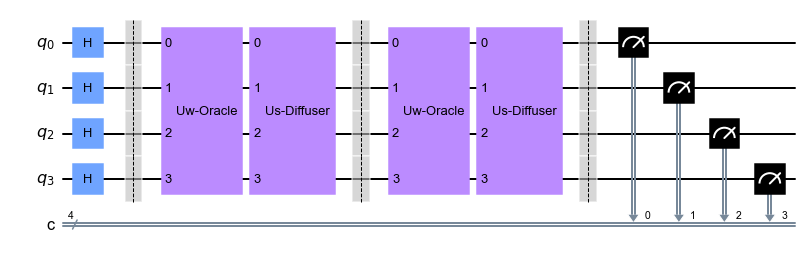

In [414]:
target = "1001"
n = len(target)
#generates a hadamard transformed state
def h_transform(target):
    num_qubits = len(target)
    #1/np.sqrt(2**num_qubits) (scale factor for hadamard transform)
    h_state = 1/np.sqrt(2**num_qubits)*np.ones((2**num_qubits, 1))
    return h_state

#Creates a statevector
def create_sv(target):
    num_qubits = len(target)
    q0 = np.array([[1.], [0.]])
    q1 = np.array([[0.], [1.]])
    elements=q0 #by default
    iterate = q0 #by default

    #giving elements an initial value
    if(target[0]=="0"):
        elements=q0
    elif(target[0]=="1"):
        elements=q1

    for i in range(1, num_qubits):
        if(target[i]=="0"):
            iterate=q0
        elif(target[i]=="1"):
            iterate=q1

        elements = np.kron(elements, iterate)
    return elements


#setting up the circuit vars
qr = qiskit.QuantumRegister(n, 'q')
cr = qiskit.ClassicalRegister(n, 'c')
qc = qiskit.QuantumCircuit(qr, cr)

#creating the circuit
#adding hadamards
for q in qr:
    qc.h(q)
qc.barrier()    

#create Uw Oracle/Gate

#Recall that Uw = I-2|w><w|

uw_gate = np.identity(2**n)-2*np.kron(create_sv(target).T, create_sv(target))

Uw_Gate = UnitaryGate(uw_gate, label="Uw-Oracle")

# Create Us Diffuser Operator

#Recall that Us = 2|s><s|-I
s = h_transform(target)#snapshot of after the hadamard transform!
us_gate = 2*np.kron(s.T, s)-np.identity(2**n)
Us_Gate = UnitaryGate(us_gate, label="Us-Diffuser")

#ADDING THE GROVER OPERATOR √N TIMES

for i in range(0, int(np.sqrt(n))):
    qc.append(Uw_Gate, qr[:n])
    qc.append(Us_Gate, qr[:n])
    qc.barrier()

#measurements
qc.measure(qr[:n], cr[:n])

qc.draw('mpl')